## Keras (frontend) & tensorflow (backend)

In [ ]:
import os
import keras

os.environ["KERAS_BACKEND"] = "tensorflow"

## Loading mnist dataset

In [1]:
from keras import datasets

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# 60000 images of 28x28 dimension
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)


Let's display the first 10 images in the dataset.

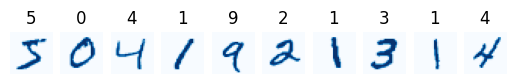

In [2]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap="Blues")
    plt.title(y_train[i])
    plt.axis("off")

## Reshape inputs
Let's now reshape the data to have a single array with 28x28=784 pixels, so that we can feed it as an input for our siamese network.

In [3]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (60000, 784)
X_test shape: (10000, 784)


## Normalization

Let's normalize each image to values between 0 and 1 via min-max normalization.

In [4]:
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

## Training model

Let's start by generating 60 000 positive pairs, and 60 000 negative pairs (120 000 pairs total) to train our siamese network.

In [10]:
import numpy as np

def generate_pairs(X, y):
    X_pairs, y_pairs = [], []

    for i in range(len(X)):
        label = y[i]

        # Positive pairs
        positive_label_index = np.random.choice(np.where(y == label)[0])
        X_pairs.append([X[i], X[positive_label_index]])
        y_pairs.append([0])

        # Negative pairs
        negative_label_index = np.random.choice(np.where(y == label)[0])
        X_pairs.append([X[i], X[negative_label_index]])
        y_pairs.append([1])

    # Braking alternate pos/neg
    indices = np.arange(len(X_pairs))
    np.random.shuffle(indices)
    
    # Return array in shuffled order
    return np.array(X_pairs)[indices], np.array(y_pairs)[indices]

In [11]:
X_train_pairs, y_train_pairs = generate_pairs(X_train, y_train)
X_test_pairs, y_test_pairs = generate_pairs(X_test, y_test)

print("X_train_pairs shape:", X_train_pairs.shape)
print("X_test_pairs shape:", X_test_pairs.shape)

X_train_pairs shape: (120000, 2, 784)
X_test_pairs shape: (20000, 2, 784)
